In [73]:
import sys
sys.path.append('../src/')

import loader
import numpy as np
import pandas as pd
from datetime import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from arch.unitroot.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

plt.rcParams['font.family'] = 'Adobe Caslon Pro'
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings("ignore")

macro_data = loader.startupMacro()
data = macro_data.load()
data.loc[:,"COVID"] = (data.index > "2020-04-01").astype(int)

In [30]:
data.head()

Type of employment activity,Start-up grant for non-unemployed,Start-up grant for unemployed,COVID
Month,,,
2006-01-31,1846.0,2060.0,0
2006-02-28,1861.0,1975.0,0
2006-03-31,1936.0,1892.0,0
2006-04-30,1969.0,1842.0,0
2006-05-31,2000.0,1845.0,0


## Testing for unit root

The whole duration of the data is used for this test statistics to avoid any potential bias.


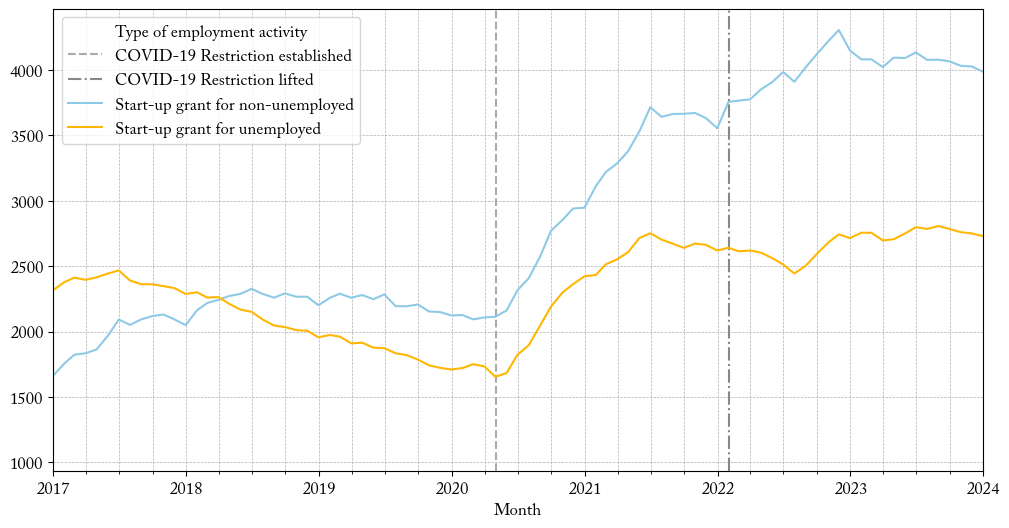

In [2]:

plt.figure(figsize=(12, 6))
plt.grid(True, which="both", ls="--", lw=0.5)

COVID = dt.strptime("2020-05-01", '%Y-%m-%d')
NORMAL = dt.strptime("2022-02-01", '%Y-%m-%d')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

plt.xlim(
	dt.strptime("2017-01-01", '%Y-%m-%d'), 
	dt.strptime("2024-01-01", '%Y-%m-%d')
	)

plt.axvline(x=COVID, color='#AAAAAA', linestyle='--',  label='COVID-19 Restriction established', lw=1.5)
plt.axvline(x=NORMAL, color='#888888', linestyle='-.',  label='COVID-19 Restriction lifted', lw=1.5)
sns.lineplot(data=data.loc[:,[
	"Start-up grant for non-unemployed",
	"Start-up grant for unemployed"
]], palette=["#8ecae6","#ffb703"], dashes=False, ax=ax)


plt.show()


In [3]:
def gen_summary(dfgls_test, name:str="unnamed") -> dict:
	summ = dfgls_test.summary().tables[0].data
	summ = {i:j for i,j in summ}
	summ["Variable"] = name
	return summ

col1 = "Start-up grant for non-unemployed"
test_1 = DFGLS(data[col1], max_lags=12, method="bic")

col2 = "Start-up grant for unemployed"
test_2 = DFGLS(data[col2], max_lags=12, method="bic")

test_results = pd.DataFrame([
	gen_summary(test_1, name=col1), 
	gen_summary(test_2, name=col2)
	]).set_index("Variable")

print(test_results)

                                  Test Statistic P-value Lags
Variable                                                     
Start-up grant for non-unemployed         -0.625   0.462    7
Start-up grant for unemployed             -1.443   0.144    7


The DF-GLS test for unit-root indicates that both series are affected by unit-root at their 7th lag, and cannot reject the existance of the unit-root.

In [31]:
col1 = "Start-up grant for non-unemployed"
data["d_emp"] = data[col1].diff()
test_1 = DFGLS(data["d_emp"].dropna(), max_lags=12, method="bic")

col2 = "Start-up grant for unemployed"
data["d_unemp"] = data[col2].diff()
test_2 = DFGLS(data["d_unemp"].dropna(), max_lags=12, method="bic")

test_results = pd.DataFrame([
	gen_summary(test_1, name=col1), 
	gen_summary(test_2, name=col2)
	]).set_index("Variable")

print(test_results)

                                  Test Statistic P-value Lags
Variable                                                     
Start-up grant for non-unemployed         -4.039   0.000    6
Start-up grant for unemployed             -1.990   0.046    6


First differencing the series resulted in a stationary series. This means that the unit-root is not cause by trend, nor drift. Hence the plausable datagenerating process is:

$$ y_{t} = \alpha_0 + \alpha_1 y_{t-1} + \varepsilon_{t} $$

Therefore further uni-variate time-series analysis could be implemented.

# Start-up grant for unemployed (count)

The autocorrelation (ACF) and partial autocorrelation (PACF) plots shows the behaviour of a autoregressive model (AR). 

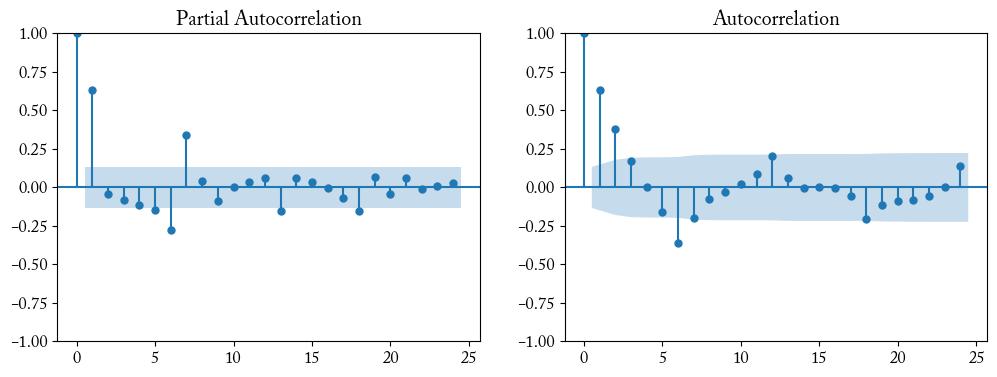

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

plot_pacf(data["d_unemp"].dropna(), lags=24, ax=ax[0])
plot_acf(data["d_unemp"].dropna(), lags=24, ax=ax[1])

plt.show()

The PACF plot shows autocorrelation at lages 1,6, and 7. Therefore they are included in the linear model. Further, two constants are added for dates 2020-05-01, 2021-12-01, where they have value 0 prior to the date, and 1 thereafter. 
These two dates were derived from the data itself, eventhough COVID restrictions were lifted two months after. 

In [7]:

data.loc[:,"COVID"] = (data.index > "2020-05-01").astype(int)
data.loc[:,"lifted"] = (data.index > "2021-02-01").astype(int)

exog_df = pd.DataFrame({
	"y_t" : data["d_unemp"],
	"COVID rest.": data["COVID"],
	"COVID lifted": data["lifted"],
	"y_t1": data["d_unemp"].shift(1),
	"y_t6": data["d_unemp"].shift(6),
	"y_t7": data["d_unemp"].shift(7)
	}).dropna()

exog_df = sm.add_constant(exog_df)

model = sm.OLS(exog_df["y_t"],exog_df.drop(columns=["y_t"])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_t   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     51.21
Date:                Sat, 02 Mar 2024   Prob (F-statistic):           3.57e-34
Time:                        18:42:27   Log-Likelihood:                -1087.0
No. Observations:                 209   AIC:                             2186.
Df Residuals:                     203   BIC:                             2206.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1913      3.479     -0.055   

The regression results shows a clear significance for both dates with coefficient for COVID restrinctions 33.51, and -30.16 for the lifted restriction. Interesting point is that the sum of these two coefficients is 3.35, indicating that the levels of application count is stablized at higher value compared to pre-COVID time. The residuals do not show any autoregressive behaviour, and therefore, the model is reliable. 

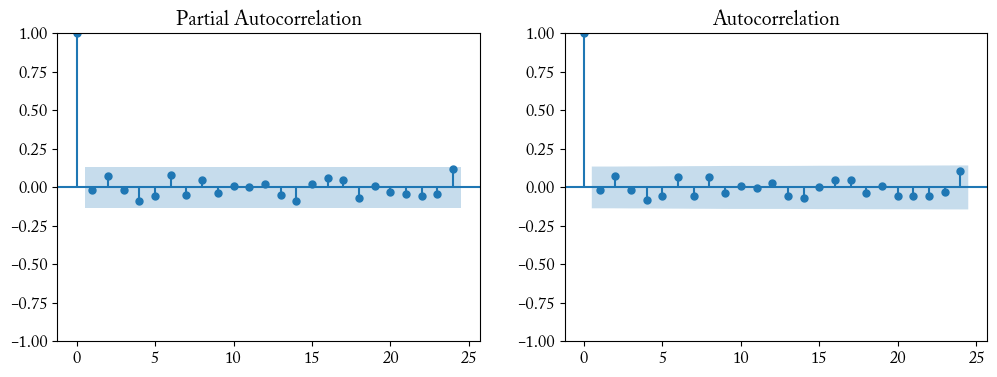

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

plot_pacf(model.resid, lags=24, ax=ax[0])
plot_acf(model.resid, lags=24, ax=ax[1])

plt.show()


# Start-up grant for employed (count)

The autocorrelation (ACF) and partial autocorrelation (PACF) plots shows similar bevaviour as the unemployed series. However, the visual inspection hints moving average behaviour. Therefore ARMA model is used with specific lags (as shown in the results table)

In [79]:
model_df = data.copy()
model_df.loc[:,"d_emp"] = model_df["Start-up grant for non-unemployed"].diff()
model_df = model_df.dropna()

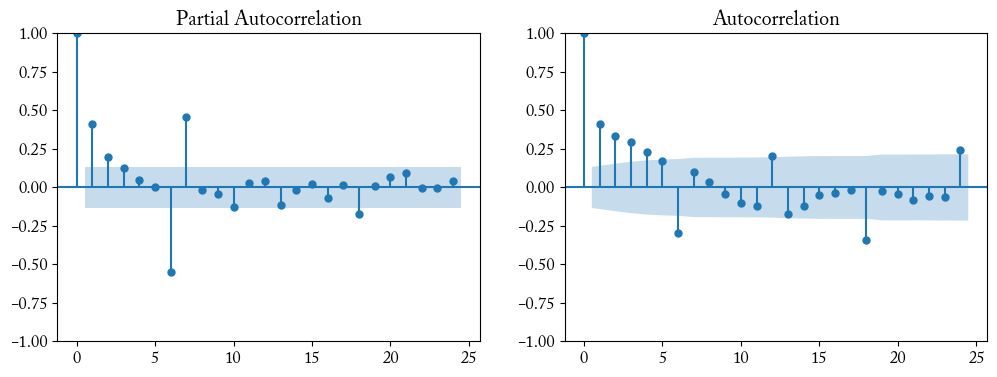

In [80]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

plot_pacf(model_df["d_emp"].dropna(), lags=24, ax=ax[0])
plot_acf(model_df["d_emp"].dropna(), lags=24, ax=ax[1])

plt.show()

In [88]:
model_df.loc[:,"COVID"] = (model_df.index > "2020-05-01").astype(int)
model_df.loc[:,"lifted"] = (model_df.index > "2021-09-01").astype(int)
model = ARIMA(model_df["d_emp"].values, exog=model_df[["COVID","lifted"]], order=((1,2,6,7),0,[2])).fit()
print(model.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  216
Model:             ARIMA([1, 2, 6, 7], 0, [2])   Log Likelihood               -1171.633
Date:                         Sat, 02 Mar 2024   AIC                           2361.265
Time:                                 19:06:07   BIC                           2391.643
Sample:                             02-28-2006   HQIC                          2373.538
                                  - 01-31-2024                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5633     10.912      0.143      0.886     -19.824      22.950
COVID         95.2048     31.568      3.016      0.003     

The results for employed time-series shows the same significance as the unemployed data. However, the magnitude of change in the levels is higher compared to unemployed data. Another important note is that the stationarity of the post COVID restrictions is starting earlier than the unemployed time series. 

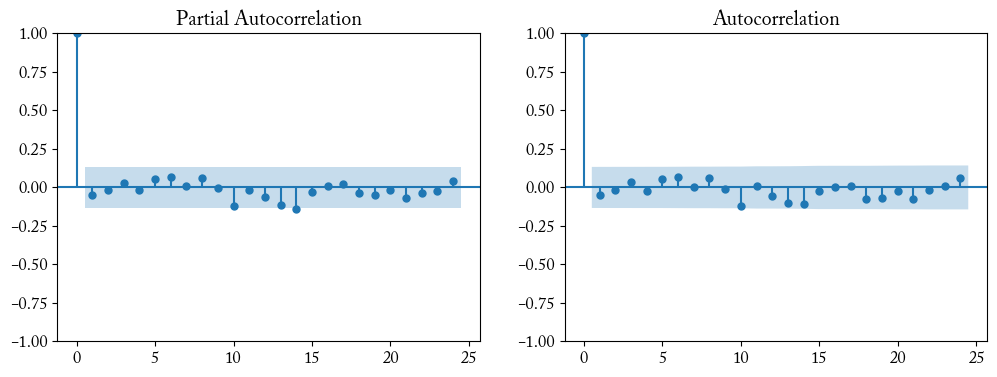

In [90]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

plot_pacf(model.resid, lags=24, ax=ax[0])
plot_acf(model.resid, lags=24, ax=ax[1])

plt.show()


The ACF and PACF plots of model residuals do not show any autoregressive behaviour. Therefore the model is fitting properly.